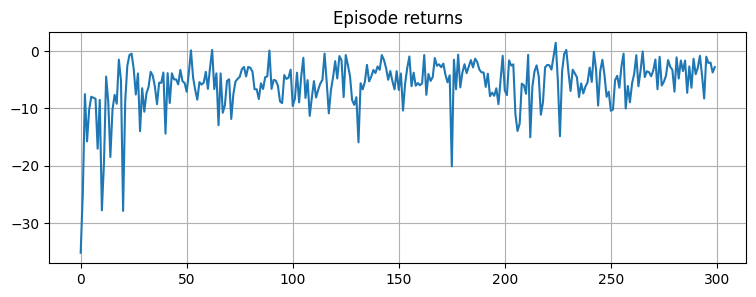

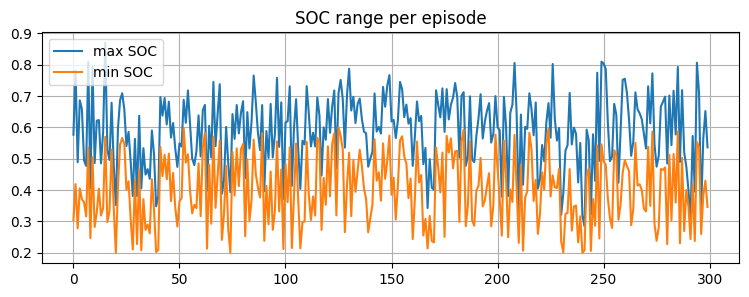

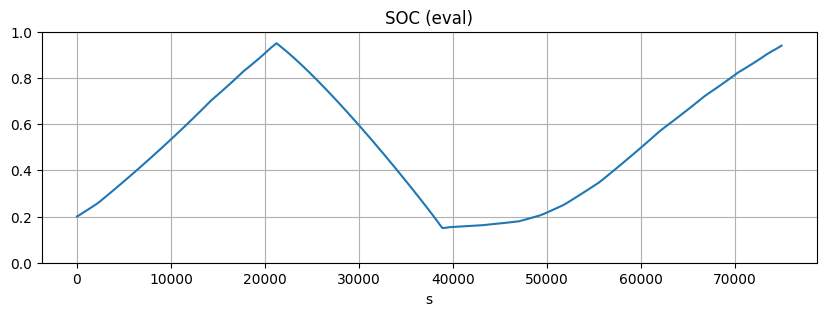

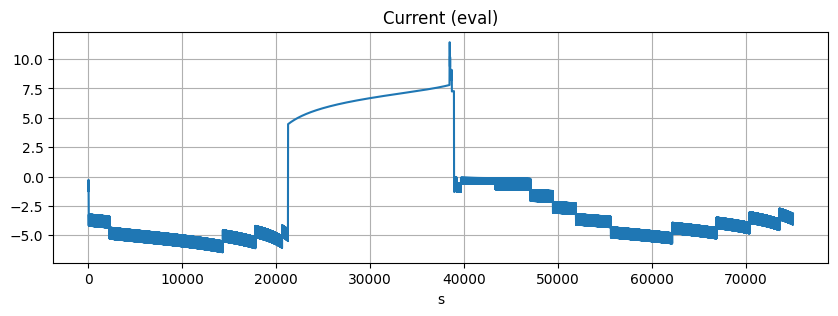

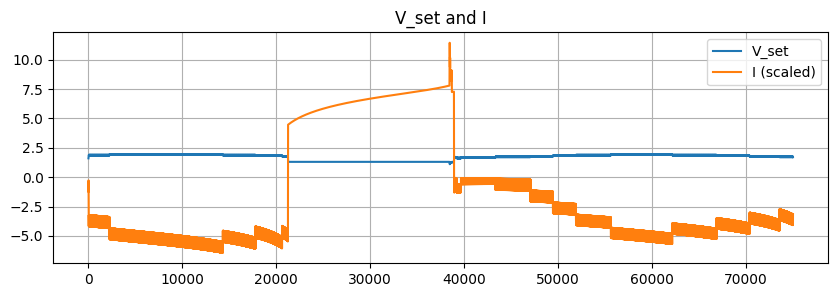

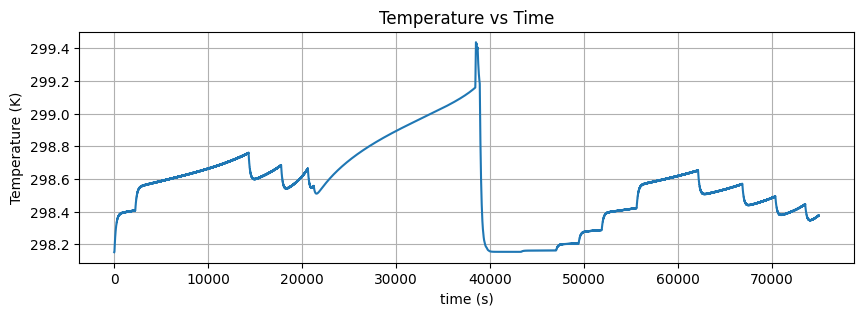

Saved: q_weights_optionA.npy


In [21]:
import numpy as np
import matplotlib.pyplot as plt


# Constants

F = 96485.33
R = 8.314
T0 = 298.15
E0 = 1.26
n = 1

C_tot = 1500.0
V_elec = 0.001

A_elec = 0.5
i0 = 50.0
alpha = 0.5

dt = 5.0            # time step (s)
T_amb = 298.15

nu_H = 2.0

R_ref = 0.05
Q_ref = 1.67e-5
beta = 0.25


I_max = 20.0
dI_max = 5.0

# setpoints 
V_discharge_nom = 0.9

# ELECTROCHEMICAL HELPERS

def soc_coulomb(I, soc_prev):
    soc_new = soc_prev - (I * dt) / (n * F * C_tot * V_elec)
    return float(np.clip(soc_new, 1e-6, 1 - 1e-6))

def eta_act(I, T):
    j = np.abs(I) / A_elec + 1e-12
    arg = np.maximum(1e-12, j/(2*i0))
    eta = (R*T)/(alpha*n*F) * np.arcsinh(arg)
    return np.sign(I) * eta

def E_ocv(soc, T, H):
    s = np.clip(soc, 1e-6, 1 - 1e-6)
    return E0 + (2*R*T/F)*(np.log((1-s)/s) + np.log(H+1e-12))

def R_ohm(T, Q):
    T = max(250, T)
    Q = max(1e-9, Q)
    return float(R_ref * (298.15/T) * (Q_ref/Q)**beta)

def temperature_next(T_prev, I, R_ohm_val, eta_act_val):
    Q_gen = I**2 * R_ohm_val + abs(I)*abs(eta_act_val)
    Q_loss = 3.0*(T_prev - T_amb)
    dTdt = (Q_gen - Q_loss)/500.0
    T_new = T_prev + dTdt*dt
    return float(np.clip(T_new, 250, 400))

def H_next(H_prev, I):
    delta_H = -(nu_H * I * dt) / (F * V_elec)
    return float(np.clip(H_prev + delta_H, 1e-3, 5000.0))

# Solve for current from set voltage using simple fixed-point (controller)
def current_from_Vset(V_set, soc, T, H, Q, I_prev=None):
    Rohm = R_ohm(T, Q)
    Eo = E_ocv(soc, T, H)
    I = 0.0 if I_prev is None else float(I_prev)
    # iterate to find I such that V_set = E_ocv - I*Rohm - eta(I)
    for _ in range(60):
        eta = eta_act(I, T)
        V_est = Eo - I*Rohm - eta
        err = V_est - V_set
        # step proportional to error / effective slope (approx Rohm)
        I += 0.5 * err / (Rohm + 1e-6)
        I = np.clip(I, -I_max, I_max)
    return float(I), Rohm, Eo


# VRFB envirement
class VRFBEnv_SOCReward:
    def __init__(self, dt=dt):
        self.dt = dt
        self.reset()
        # bounds
        self.V_min, self.V_max = 0.7, 2.2
        self.Q_min, self.Q_max = 1e-6, 5e-5
        # thresholds
        self.soc_full = 0.95
        self.soc_empty = 0.15

    def reset(self, soc=0.2, T=None, V_set=None, Q=None, mode=0):
        self.SOC = float(soc)
        self.T = T0 if T is None else float(T)
        self.H = 1000.0
        self.mode = int(mode)   # 0 = charge, 1 = discharge
        self.V_set = V_charge_nom if V_set is None else float(V_set)
        self.Q = 2e-5 if Q is None else float(Q)
        self.I_prev = 0.0
        return self._obs()

    def _obs(self):
        # state given to agent: [V_set, SOC, T, Q, mode]
        return np.array([self.V_set, self.SOC, self.T, self.Q, float(self.mode)], dtype=float)

    def _auto_switch(self):
        if self.mode == 0 and self.SOC >= self.soc_full:
            self.mode = 1
        elif self.mode == 1 and self.SOC <= self.soc_empty:
            self.mode = 0

    def step(self, action):
        """
        action: integer index -> map to (dV, dQ)
        We'll allow small change in V_set and Q.
        """
        self._auto_switch()

        dV, dQ = ACTIONS[action]
        # allow small delta V but keep within bounds
        self.V_set = float(np.clip(self.V_set + dV, self.V_min, self.V_max))
        self.Q = float(np.clip(self.Q + dQ, self.Q_min, self.Q_max))

        # enforce nominal V_set for mode sign guidance (but keep small V tuning allowed)
        if self.mode == 0:
            # charging mode: bias V_set toward V_charge_nom (agent can only tweak slightly)
            self.V_set = np.clip(self.V_set, 1.6, self.V_max)
        else:
            self.V_set = np.clip(self.V_set, self.V_min, 1.3)

        # compute current (no restrictive smoothing)
        I, Rohm, Eo = current_from_Vset(self.V_set, self.SOC, self.T, self.H, self.Q, I_prev=None)

        # Strongly discourage wrong sign and immediate force to correct sign if necessary:
        # In our sign convention I<0 -> SOC increases (charging), I>0 -> SOC decreases
        # If mode==0 (charge) but I>0 (discharging), penalize and flip sign a bit (controller override)
        if self.mode == 0 and I > 0:
            # penalize; and nudge I negative to ensure charging proceeds
            I = -np.abs(I) * 0.7
        if self.mode == 1 and I < 0:
            I = np.abs(I) * 0.7

        prev_SOC = self.SOC
        self.SOC = soc_coulomb(I, prev_SOC)
        eta = eta_act(I, self.T)
        self.T = temperature_next(self.T, I, Rohm, eta)
        self.H = H_next(self.H, I)
        self.I_prev = I

        #  Reward shaping 
        # 1) reward terminal voltage closeness (effic proxy)
        V_t = Eo - I*Rohm - eta
        volt_reward = -abs(V_t - self.V_set)

        # 2) temperature penalty (keep near ambient)
        temp_penalty = -0.02 * abs(self.T - T_amb)

        # 3) current magnitude penalty (avoid unnecessarily large current)
        cur_penalty = -0.0005 * abs(I)

        # 4) SOC directional reward: reward progress toward mode target
        delta_soc = self.SOC - prev_SOC
        if self.mode == 0:
            # want SOC increase
            soc_progress = 50.0 * max(0.0, delta_soc)
            wrong_sign_penalty = -30.0 * max(0.0, I)   # I>0 during charge -> penalty
        else:
            soc_progress = 50.0 * max(0.0, -delta_soc)
            wrong_sign_penalty = -30.0 * max(0.0, -I)  # I<0 during discharge -> penalty

        # 5) BIG bonuses for reaching targets (encourage completion)
        bonus = 0.0
        if self.mode == 0 and prev_SOC < self.soc_full and self.SOC >= self.soc_full:
            bonus += 200.0   # reached full charge
        if self.mode == 1 and prev_SOC > self.soc_empty and self.SOC <= self.soc_empty:
            bonus += 200.0   # reached empty

        reward = 10.0*volt_reward + temp_penalty + cur_penalty + soc_progress + wrong_sign_penalty + bonus

        done = False
        info = {"I": I, "V_t": V_t, "Eo": Eo, "Rohm": Rohm}
        return self._obs(), float(reward), done, info

# ACTION SPACE
# Agent selects a discrete pair: 
#   action = (dV, dQ)
# dV = small change in voltage setpoint
# dQ = small change in effective flow/electrolyte volume factor
dV_list = [-0.05, 0.0, 0.05]
dQ_list = [-0.5e-6, 0.0, 0.5e-6]
ACTIONS = [(dv, dq) for dv in dV_list for dq in dQ_list]
N_ACTIONS = len(ACTIONS)

# STATE FEATURE TRANSFORMATION
# state s = [V_set, SOC, T, Q, mode]
# normalized → linear model stability
# quadratic basis → includes nonlinear interactions
def featurize(state):
    V, soc, T, Q, mode = state
    Vn = (V - 1.45) / 0.5
    sonn = (soc - 0.5) / 0.5
    Tn = (T - 298.15) / 50.0
    Qn = (Q - 2e-5) / 1e-5
    mode_n = mode
    base = np.array([1.0, Vn, sonn, Tn, Qn, mode_n])
    quad = np.outer(base, base)[np.triu_indices(base.shape[0])]
    return np.concatenate([base, quad])

# initialize weights
rng = np.random.RandomState(0)
phi0 = featurize(np.array([1.45,0.2,298.15,2e-5,0.0]))
FEATURE_DIM = phi0.size
W = rng.normal(scale=0.01, size=(N_ACTIONS, FEATURE_DIM))

# Q-FUNCTION APPROXIMATION
# Q(s,a) = W[a] · ϕ(s)
# Linear function approximation
def q_vals(state):
    phi = featurize(state)
    return W.dot(phi), phi

# ACTION SELECTION: ε-greedy policy
# With probability ε: explore (random action)
# With probability 1-ε: exploit (argmax Q)
def select_eps_greedy(state, eps):
    if rng.rand() < eps:
        return rng.randint(N_ACTIONS)
    q, _ = q_vals(state)
    return int(np.argmax(q))

# Q-LEARNING UPDATE (Temporal-Difference Learning)
# Update rule:
#   Q(s,a) ← Q(s,a) + α [r + γ max_a' Q(s',a') − Q(s,a)]
# Rewritten in weight:
#   W[a] ← W[a] + α * TD_error * φ(s)
# Where:
#   TD_error = (r + γ max Q(s',·) − Q(s,a))
def q_update(s,a,r,s2,alpha=1e-3,gamma=0.98):
    q, phi = q_vals(s)
    q2, _ = q_vals(s2)
    target = r + gamma * np.max(q2)
    td = target - q[a]
    W[a] += alpha * td * phi


# TRAINING LOOP
# For each episode:
#   1. reset VRFB environment
#   2. take actions using ε-greedy
#   3. update Q-weights using Q-learning rule
#   4. store episode metrics (total reward, SOC range)
env = VRFBEnv_SOCReward()
n_episodes = 300
ep_len = 1200   # long episodes to allow charging close to 1
eps_start = 0.6
eps_end = 0.02

history = {"totrew": [], "max_soc": [], "min_soc": []}

for ep in range(n_episodes):
    eps = max(eps_end, eps_start * (1 - ep / n_episodes))
    s = env.reset(soc=0.2 + 0.4*rng.rand(), T=298.15 + 1.0*(rng.rand()-0.5), V_set=1.45, Q=2e-5, mode=0)
    tot = 0.0
    socs = []
    for t in range(ep_len):
        a = select_eps_greedy(s, eps)
        s2, r, done, info = env.step(a)
        q_update(s,a,r,s2, alpha=2e-3, gamma=0.98)
        s = s2
        tot += r
        socs.append(s[1])
    history["totrew"].append(tot)
    history["max_soc"].append(np.max(socs))
    history["min_soc"].append(np.min(socs))


# PLOT training summary + evaluate greedy policy long run
plt.figure(figsize=(9,3)); plt.plot(history["totrew"]); plt.title("Episode returns"); plt.grid(); plt.show()
plt.figure(figsize=(9,3)); plt.plot(history["max_soc"], label='max SOC'); plt.plot(history["min_soc"], label='min SOC'); plt.legend(); plt.title("SOC range per episode"); plt.grid(); plt.show()

# Evaluate greedy policy for a long run
# POLICY EVALUATION (greedy)
# After training:
#   Run agent with eps=0 (pure exploitation)
def eval_policy(env, steps=10000):
    s = env.reset(soc=0.2, T=298.15, V_set=1.45, Q=2e-5, mode=0)
    traj = {"time":[], "SOC":[], "T":[], "V_set":[], "Q":[], "I":[], "mode":[]}
    for t in range(steps):
        a = select_eps_greedy(s, eps=0.0)
        s, r, d, info = env.step(a)
        traj["time"].append(t*dt); traj["SOC"].append(s[1]); traj["T"].append(s[2])
        traj["V_set"].append(s[0]); traj["Q"].append(s[3]); traj["I"].append(info["I"])
        traj["mode"].append(int(s[4]))
    return traj

traj = eval_policy(env, steps=15000)

plt.figure(figsize=(10,3)); plt.plot(traj["time"], traj["SOC"]); plt.title("SOC (eval)"); plt.xlabel("s"); plt.grid(); plt.ylim(0,1); plt.show()
plt.figure(figsize=(10,3)); plt.plot(traj["time"], traj["I"]); plt.title("Current (eval)"); plt.xlabel("s"); plt.grid(); plt.show()
plt.figure(figsize=(10,3)); plt.plot(traj["time"], traj["V_set"], label='V_set'); plt.plot(traj["time"], traj["I"], label='I (scaled)'); plt.legend(); plt.grid(); plt.title("V_set and I"); plt.show()



plt.figure(figsize=(10,3))
plt.plot(traj["time"], traj["T"])
plt.title("Temperature vs Time")
plt.xlabel("time (s)")
plt.ylabel("Temperature (K)")
plt.grid()
plt.show()


# Save weights
np.save("q_weights_optionA.npy", W)
print("Saved: q_weights_optionA.npy")
